In [5]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np

# Visualization
import seaborn as sns
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import statsmodels.api as sm

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [6]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

In [7]:
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

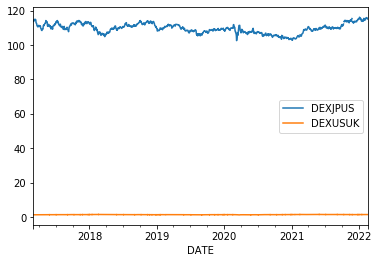

In [8]:
ccy_data.plot();

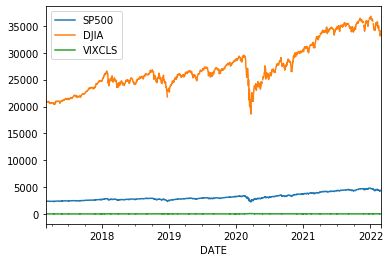

In [9]:
idx_data.plot();

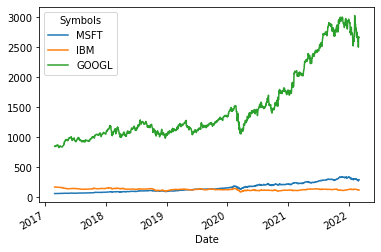

In [10]:
stk_data['Open'].plot();

In [11]:
return_period = 5

In [12]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)

In [13]:
Y.name = 'MSFT_pred'

In [14]:
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()

X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, 
                                                                            return_period * 3, 
                                                                            return_period * 6, 
                                                                            return_period * 12]
          ], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1,X2,X3,X4], axis=1)

dataset = pd.concat([X,Y], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

#### Exploratory data analysis

##### 3.1 Descriptive analysis

In [15]:
pd.set_option('precision', 3)
dataset.describe()

,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT,MSFT_pred
count,2.250e+02,225.000,2.250e+02,2.250e+02,225.000,225.000,225.000,225.000,225.000,225.000,225.000,225.000
mean,3.859e-04,0.004,3.789e-04,-2.274e-04,0.003,0.002,-0.003,0.007,0.019,0.041,0.083,0.007
std,3.493e-02,0.035,9.443e-03,1.243e-02,0.022,0.024,0.164,0.030,0.049,0.061,0.072,0.029
min,-1.569e-01,-0.131,-3.572e-02,-7.346e-02,-0.131,-0.164,-0.447,-0.120,-0.149,-0.238,-0.134,-0.120
25%,-1.667e-02,-0.013,-4.482e-03,-7.331e-03,-0.005,-0.006,-0.091,-0.012,-0.005,0.009,0.041,-0.011
50%,2.154e-03,0.008,4.710e-04,-5.560e-04,0.004,0.003,-0.020,0.011,0.025,0.046,0.084,0.011
75%,1.924e-02,0.026,5.537e-03,8.453e-03,0.013,0.012,0.069,0.025,0.049,0.080,0.131,0.024
max,9.203e-02,0.136,3.683e-02,5.530e-02,0.059,0.079,0.992,0.077,0.147,0.244,0.306,0.077


In [16]:
dataset.head()

,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT,MSFT_pred
2017-05-25,0.016,0.043,0.008,-4.237e-03,0.021,0.020,-0.384,0.028,0.017,0.071,0.075,0.030
2017-06-02,-0.008,0.004,-0.007,7.009e-03,0.010,0.006,-0.006,0.030,0.053,0.097,0.105,-0.020
2017-06-12,0.018,-0.043,-0.007,-2.025e-02,-0.003,0.002,0.129,-0.035,0.030,0.025,0.082,0.015
2017-06-19,-0.002,0.014,0.015,6.693e-03,0.010,0.014,-0.100,0.015,0.013,0.032,0.094,-0.005
2017-06-26,0.003,-0.003,0.001,-8.636e-04,-0.006,-0.006,-0.046,-0.005,-0.025,0.037,0.077,-0.034


In [17]:
dataset.dtypes

IBM          float64
GOOGL        float64
DEXJPUS      float64
DEXUSUK      float64
SP500        float64
DJIA         float64
VIXCLS       float64
MSFT_DT      float64
MSFT_3DT     float64
MSFT_6DT     float64
MSFT_12DT    float64
MSFT_pred    float64
dtype: object

##### 3.2 Data visualization

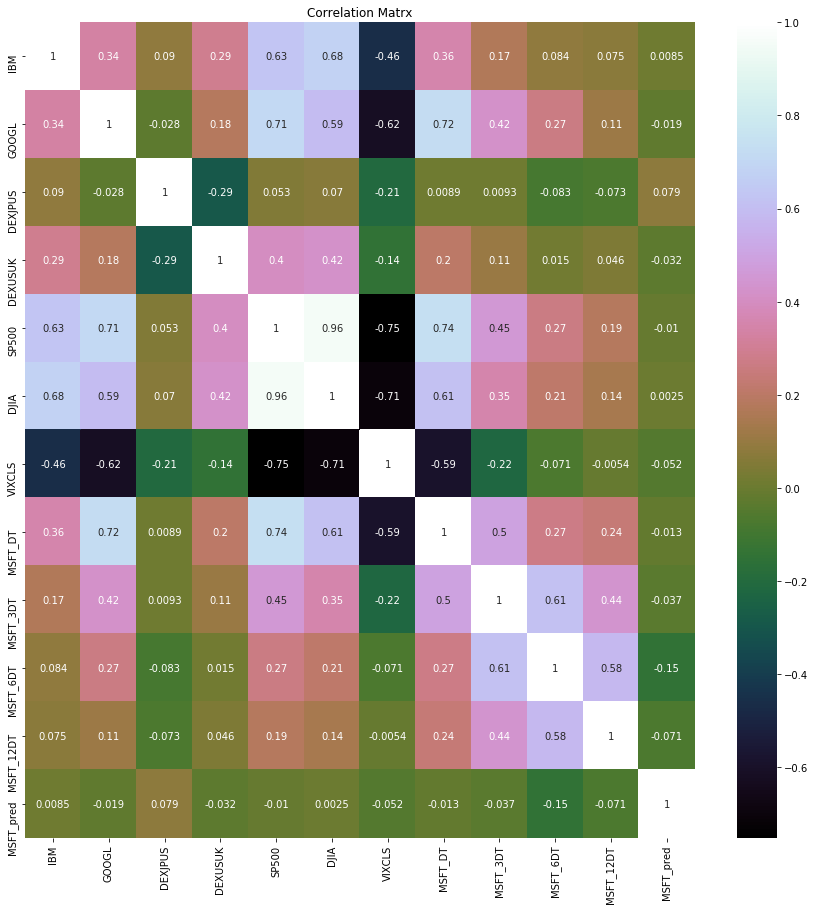

In [18]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrx')
sns.heatmap(correlation, vmax=1, annot=True, cmap='cubehelix')

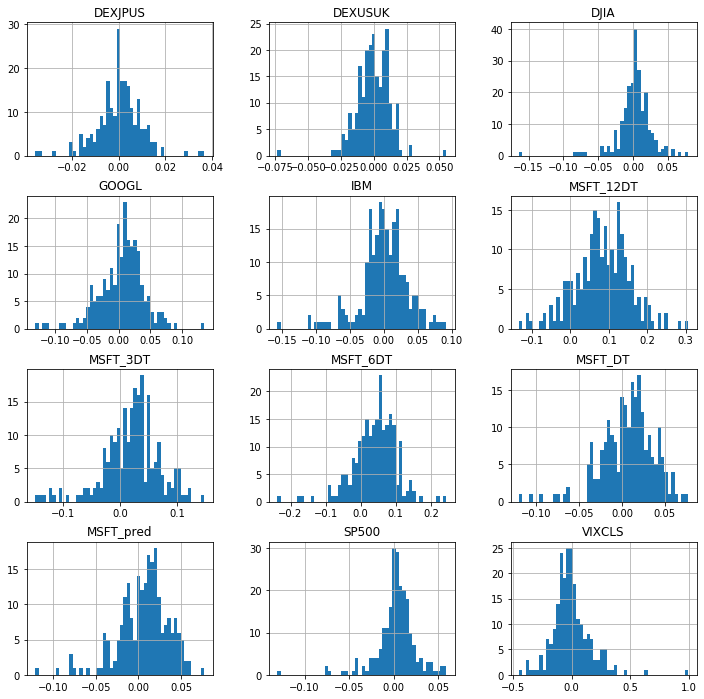

In [19]:
dataset.hist(bins=50, sharex=False, sharey=False,figsize=(12,12));

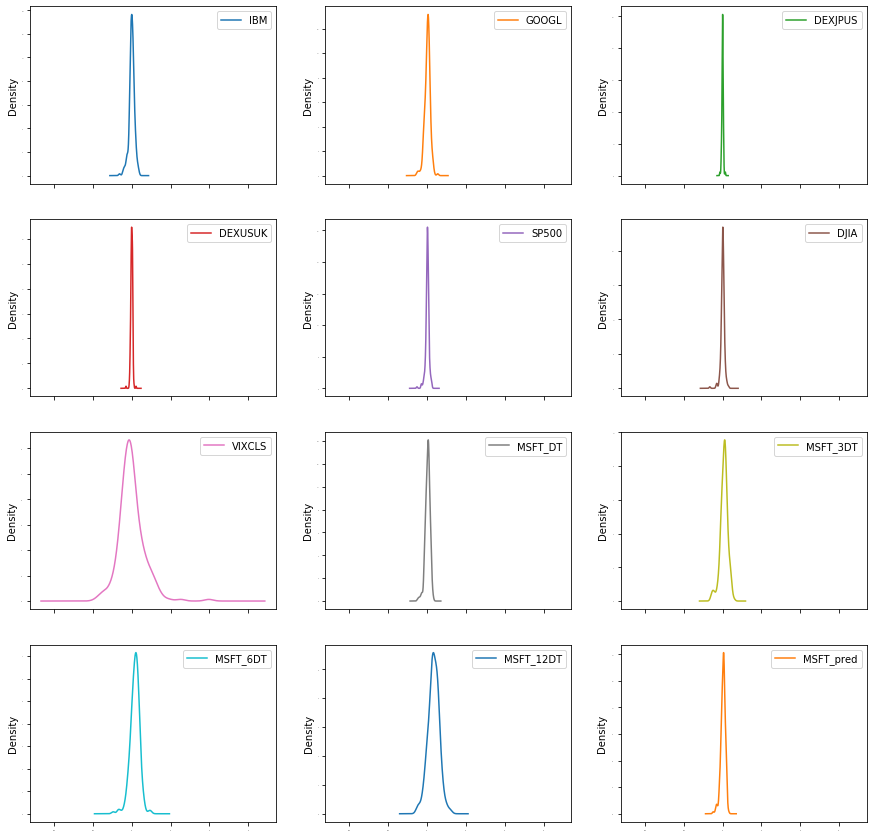

In [20]:
dataset.plot(kind='density', subplots=True, layout=(4,3), legend=True, fontsize=1, sharex=True, figsize=(15,15));

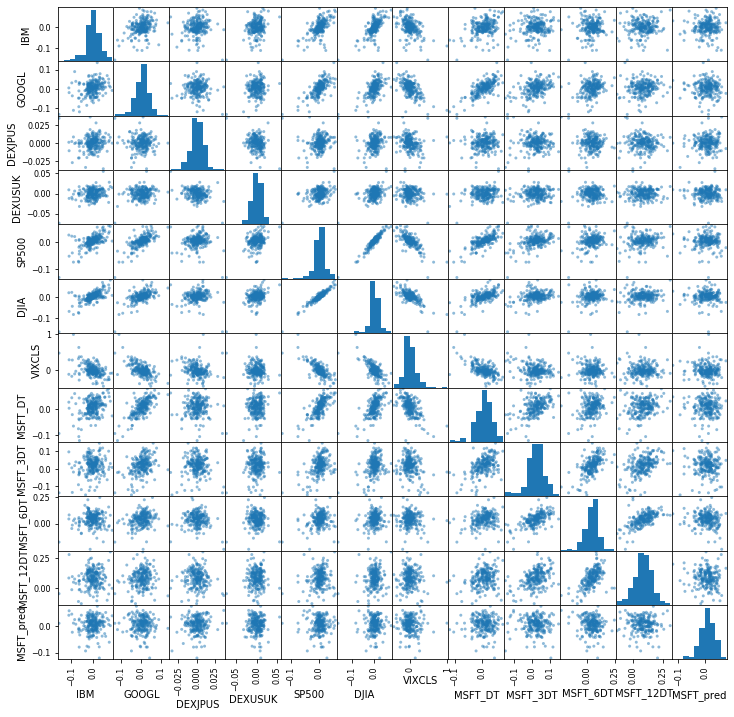

In [21]:
scatter_matrix(dataset, figsize=(12,12));

##### 3.3 Time Series Analysis

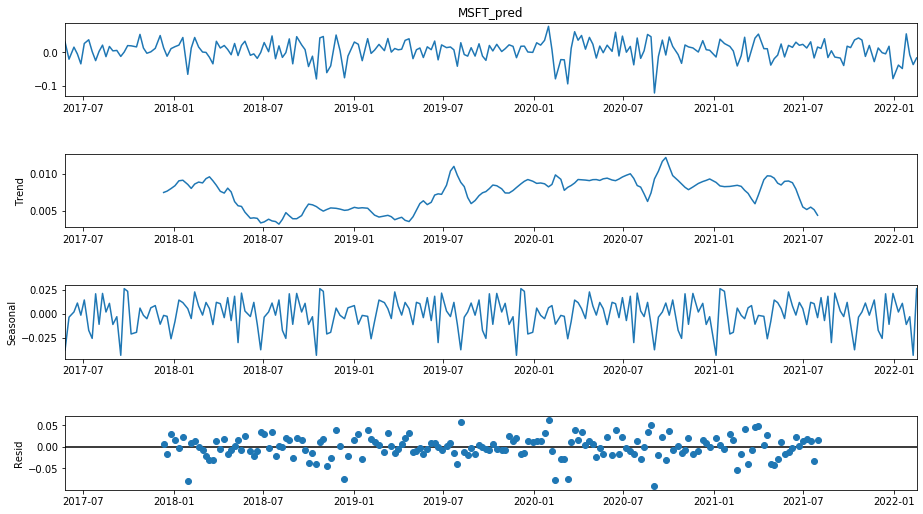

In [22]:
res = sm.tsa.seasonal_decompose(Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

#### 4. Data Preparation
###### 4.2. Feature Selection

In [23]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
featureScores.nlargest(10, 'Score').set_index('Specs')

,Score
Specs,
MSFT_6DT,4.914
DEXJPUS,1.403
MSFT_12DT,1.140
VIXCLS,0.594
MSFT_3DT,0.310
DEXUSUK,0.224
GOOGL,0.083
MSFT_DT,0.040
SP500,0.022


#### 5. Evalute Algorithms and models

##### 5.1 Train test split and evaluation metrics

In [24]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

##### 5.2 Test Options and evaluation metrics

In [25]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

##### 5.3 Compare Models and Algorithms

###### 5.3.1 Machine learning models from scikit-learn

In [26]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('RID', Ridge()))

# Neural Network algorithms
models.append(('LR', MLPRegressor()))

# Ensamble models
#  Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

#  Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [27]:
names = []
kfold_results = []

for name, model in models:
    names.append(name)
    
    # K Fold analysis:
    kfold = KFold(n_splits=num_folds)
    cv_result = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_result)
    
    # TODO: next ssession

kfold_results

[array([0.00040919, 0.0007274 , 0.0003973 , 0.00157701, 0.00089425,
        0.00043955, 0.0002737 , 0.00266023, 0.00199405, 0.00057834]),
 array([0.00037995, 0.00074416, 0.0003554 , 0.00154276, 0.00080711,
        0.00042609, 0.00023996, 0.00184121, 0.00176487, 0.00055582]),
 array([0.00037995, 0.00074416, 0.0003554 , 0.00154276, 0.00080711,
        0.00042609, 0.00023996, 0.00184121, 0.00176487, 0.00055582]),
 array([0.00055463, 0.00115218, 0.00064241, 0.00165977, 0.00084719,
        0.00045485, 0.00035316, 0.00177953, 0.00169366, 0.00051936]),
 array([0.00121937, 0.00143092, 0.00143091, 0.0020115 , 0.00244213,
        0.00170688, 0.00066229, 0.0033981 , 0.00200227, 0.00121312]),
 array([0.00104042, 0.00199678, 0.00105319, 0.00186696, 0.0017939 ,
        0.00118175, 0.00114686, 0.00339717, 0.00206663, 0.00129978]),
 array([0.00036981, 0.00072735, 0.00035647, 0.0015775 , 0.00078911,
        0.00042337, 0.00024232, 0.0019091 , 0.00174864, 0.00052833]),
 array([0.00039264, 0.00083168, 0.